# Notebook used to estimate epidemic waves

In [1]:
import pandas as pd
from functools import reduce
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.stats import skewnorm
import json

In [144]:
df = pd.read_csv('data/world_r_eff.csv',
        usecols=['country','date','R'],
        squeeze=True
        ).sort_index()
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

In [146]:
df[df.country == 'Norway'].describe()

,R
count,417.000000
mean,1.087854
std,0.347388
min,0.604291
25%,0.868049
50%,1.051922
75%,1.208514
max,3.054147


In [3]:
trend_length = 14
logic_func = lambda r: reduce(lambda x, y: x + 1 if y else 0, r)

In [4]:
df_total = pd.DataFrame(columns=['country',	'date',	'R', 'upward_slope_days', 'downward_slope_days' ])
for country in tqdm(df.country.unique()):
    df_country = df.loc[df['country'] == country]
    
    # counts number consecutive days with R>=1 for a give date
    ser = df.loc[df['country'] == country]['R'] > 1
    df_country['upward_slope_days'] = ser.expanding().apply(logic_func)

    # counts number consecutive days with R<1 for a give date
    ser = df_country['R'] < 1
    df_country['downward_slope_days'] = ser.expanding().apply(logic_func)

    #df_country = df_country[(df_country.upward_slope_days > 14) | (df_country.downward_slope_days > 14)]
    # append df to total_df
    df_total = pd.concat([df_total, df_country])
df_total = df_total[~df_total.country.isin(df_total[df_total.R < 0.6].country.unique())]
df_total = df_total[df_total.country != 'World']
df_total = df_total.reset_index().drop('index', axis=1)

100%|██████████| 182/182 [00:09<00:00, 19.13it/s]


In [10]:
ser = df_total['upward_slope_days'] >= 14
mask1 = df_total.index.isin(df_total['upward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_total['downward_slope_days'] >= 14
mask2 = df_total.index.isin(df_total['downward_slope_days'][ser & (ser != ser.shift(-1))].index)
df_wave = df_total[mask1 | mask2]

In [11]:
df_new = pd.DataFrame(columns=list(df_total.columns) + ['upward_period', 'downward_period'])
current_country = ""
slope_count = 1.0
mask = df_total['upward_slope_days'] >= 14
ix = df_total['upward_slope_days'][mask & (mask != mask.shift(-1))].index
for i in tqdm(ix):
    new_country = df_total.iloc[i].country
    if current_country != new_country:
        slope_count = 1.0
        current_country = new_country
    val = int(df_total.iloc[i]['upward_slope_days'])
    first_ix = i-val+1
    df_temp = df_total.iloc[first_ix:i+1]
    df_temp['upward_period'] = slope_count
    df_temp['downward_period'] = np.nan
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
    slope_count += 1.0
mask = df_total['downward_slope_days'] >= 14
ix = df_total['downward_slope_days'][mask & (mask != mask.shift(-1))].index
for i in tqdm(ix):
    new_country = df_total.iloc[i].country
    if current_country != new_country:
        slope_count = 1.0
        current_country = new_country
    val = int(df_total.iloc[i]['downward_slope_days'])
    first_ix = i-val+1
    df_temp = df_total.iloc[first_ix:i+1]
    df_temp['upward_period'] = np.nan
    df_temp['downward_period'] = slope_count
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
    slope_count += 1.0

countries = df_total.country.unique()
for c in tqdm(countries):
    df_total_country = df_total[df_total.country == c]
    df_new_country = df_new[df_new.country == c]
    neutral_dates = set(df_total_country.date) - set(df_new_country.date)
    mask1 = df_total.country == c
    mask2 = df_total.date.isin(neutral_dates)
    df_temp = df_total[mask1 & mask2]
    empty_series = np.empty(len(df_temp))
    empty_series[:] = np.nan
    df_temp['upward_period'] = empty_series
    df_temp['downward_period'] = empty_series
    dt = df_temp.date
    in_block = dt - dt.shift(1) == pd.Timedelta('1d')
    df_temp['neutral_period'] = np.zeros(len(df_temp))
    ix = in_block[~in_block].index
    for i in ix:
        df_temp.at[i, 'neutral_period'] = 1.0
    df_temp['neutral_period'] = np.cumsum(df_temp['neutral_period'])
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
df_new = df_new.sort_values(by=['country', 'date']).reset_index().drop('index', axis=1)
mask1 = df_new.neutral_period > 0
mask2 = df_new.upward_period > 0
mask3 = df_new.downward_period > 0
is_neutral = pd.Series(mask1 & ~(mask2 | mask3))
func = lambda r: reduce(lambda x,y: x + 1 if y else 0, r)
tqdm.pandas()
df_new['neutral_slope_days'] = is_neutral.expanding().progress_apply(func)

100%|██████████| 93/93 [00:01<00:00, 87.91it/s]
35859it [01:31, 392.65it/s]


In [12]:
df_new = df_new[['country', 'date', 'R', 'upward_slope_days','upward_period','downward_slope_days','downward_period','neutral_slope_days','neutral_period']]
df_new.to_csv('data/world_wave_data.csv', index=False)

In [13]:
ser = df_new['upward_slope_days'] >= 14
mask1 = df_new.index.isin(df_new['upward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_new['downward_slope_days'] >= 14
mask2 = df_new.index.isin(df_new['downward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_new['neutral_slope_days'] > 0
mask3 = df_new.index.isin(df_new['neutral_slope_days'][ser & (ser != ser.shift(-1))].index)
df_wave = df_new[mask1 | mask2 | mask3]

In [18]:
df_count = df_wave[['country','upward_period', 'downward_period', 'neutral_period']]
df_count['upward_period'] = df_count['upward_period'].apply(lambda x: True if x > 0 else False)
df_count['downward_period'] = df_count['downward_period'].apply(lambda x: True if x > 0 else False)
df_count['neutral_period'] = df_count['neutral_period'].apply(lambda x: True if x > 0 else False)
count_matrix = {
    "U": {
        "U": 0,
        "D": 0,
        "N": 0
    },
    "D": {
        "U": 0,
        "D": 0,
        "N": 0
    },
    "N":{
        "U": 0,
        "D": 0,
        "N": 0
    }
}
for c in tqdm(df_count.groupby('country')):
    df = c[1]
    previous = ""
    for i, row in enumerate(df.iterrows()):
        info = row[1]
        current = ""
        if info.upward_period:
            current = "U"
        elif info.downward_period:
            current = "D"
        elif info.neutral_period:
            current = "N"
        if previous:
            count_matrix[previous][current] += 1
        previous = current

wave_transition_df = pd.DataFrame(count_matrix)
wave_transition_df = wave_transition_df/wave_transition_df.sum(axis=1).to_numpy().reshape(-1,1)

100%|██████████| 93/93 [00:00<00:00, 903.47it/s]


In [19]:
wave_transition_df.to_csv('data/wave_transition.csv')

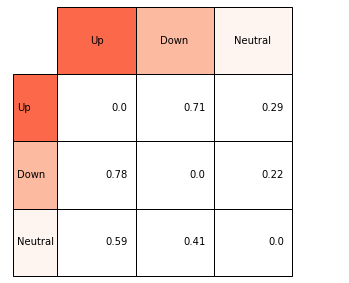

In [141]:
col_labels = ["Up", "Down", "Neutral"]
row_labels = col_labels
plt.figure()
table = plt.table(cellText=np.round(wave_transition_df.values,2),
                      colLabels=col_labels,
                      rowLabels=row_labels,
                      rowColours=plt.cm.Reds(np.linspace(0, 0.5, len(col_labels))[::-1]),
                      colColours=plt.cm.Reds(np.linspace(0, 0.5, len(col_labels))[::-1]),
                      loc='center')
s = 0.7
table.scale(s,s*8)
# plt.title('Transition probaility matrix')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.show()

In [20]:
up_R_params = df_new.groupby(['upward_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
up_R_params.columns = up_R_params.columns.get_level_values(1)
up_R_params.index = up_R_params.index.astype(int)

down_R_params = df_new.groupby(['downward_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
down_R_params.columns = down_R_params.columns.get_level_values(1)
down_R_params.index = down_R_params.index.astype(int)

neutral_R_params = df_new.groupby(['neutral_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
neutral_R_params.columns = neutral_R_params.columns.get_level_values(1)
neutral_R_params.index = neutral_R_params.index.astype(int)

In [21]:
up_period_params = df_up.groupby(['upward_period']).aggregate({"upward_slope_days": ["count","mean","min", "max", "skew", "std"]})
up_period_params.columns = up_period_params.columns.get_level_values(1)
up_period_params.index = up_period_params.index.astype(int)

down_period_params = df_down.groupby(['downward_period']).aggregate({"downward_slope_days": ["count","mean","min", "max", "skew", "std"]})
down_period_params.columns = down_period_params.columns.get_level_values(1)
down_period_params.index = down_period_params.index.astype(int)

neutral_period_params = df_neutral.groupby(['neutral_period']).aggregate({"neutral_slope_days": ["count","mean","min", "max", "skew", "std"]})
neutral_period_params.columns = neutral_period_params.columns.get_level_values(1)
neutral_period_params.index = neutral_period_params.index.astype(int)

In [22]:
data = {}
R = {}
labels = ['U', 'D', 'N']
for i, df in enumerate([up_R_params, down_R_params, neutral_R_params]):
    R[labels[i]] = json.loads(df.to_json(orient='index'))
duration = {}
for i, df in enumerate([up_period_params, down_period_params, neutral_period_params]):
    duration[labels[i]] = json.loads(df.to_json(orient='index'))
data['R'] = R
data['duration'] = duration

In [23]:
with open('data/wave_parameters.json', 'w') as file:
    json.dump(data, file, indent=4)

In [90]:
ser = df_new['upward_slope_days'] > 0
up = df_new['upward_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'upward_slope_days':'days'})
up['slope'] = pd.Series(['Upward' for _ in range(len(up))])

ser = df_new['downward_slope_days'] > 0
down = df_new['downward_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'downward_slope_days':'days'})
down['slope'] = pd.Series(['Downward' for _ in range(len(down))])

ser = df_new['neutral_slope_days'] > 0
neutral = df_new['neutral_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'neutral_slope_days':'days'})
neutral['slope'] = pd.Series(['Neutral' for _ in range(len(neutral))])

df_dist = pd.concat([up, down, neutral])

<Figure size 842.4x595.44 with 0 Axes>

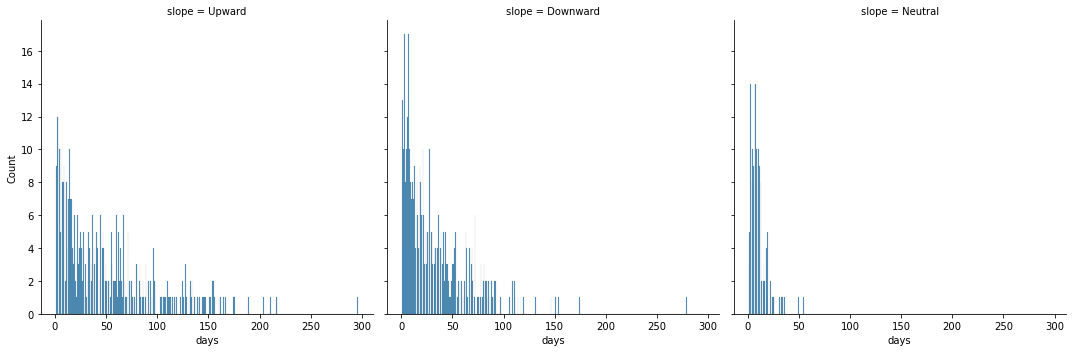

In [91]:
a4_dims = (11.7, 8.27)
plt.figure(figsize=a4_dims)
sns.displot(df_dist, x='days', col='slope', kind='hist', fill=True, height=5, aspect=1, bins=len(count_up_dist))
plt.show()

<Figure size 842.4x595.44 with 0 Axes>

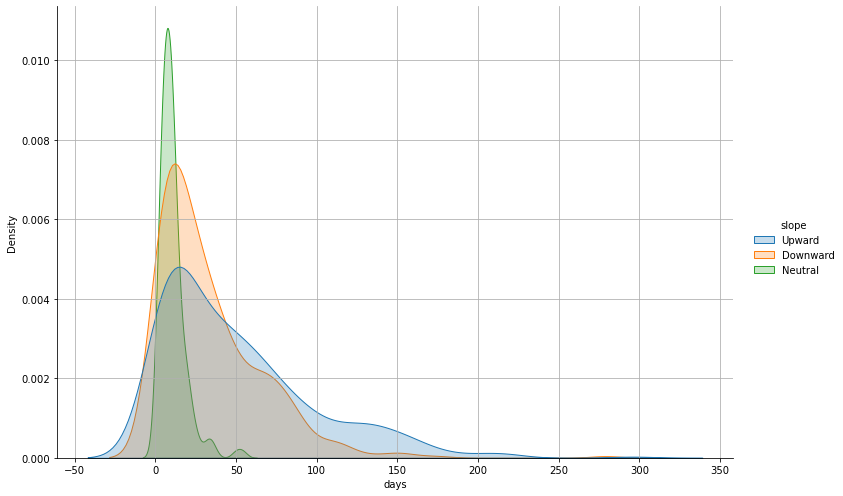

In [92]:
a4_dims = (11.7, 8.27)
plt.figure(figsize=a4_dims)
sns.displot(df_dist, x='days', hue='slope', kind='kde', fill=True, height=7, aspect=1.5)
plt.grid()
plt.show()

In [14]:
df_up = df_wave[df_wave.upward_period > 0].drop(['downward_period', 'downward_slope_days', 'neutral_slope_days', 'neutral_period'], axis=1)
df_down = df_wave[df_wave.downward_period > 0].drop(['upward_period', 'upward_slope_days', 'neutral_slope_days', 'neutral_period'], axis=1)
df_neutral = df_wave[df_wave.neutral_period > 0].drop(['upward_period', 'upward_slope_days','downward_period', 'downward_slope_days'], axis=1)

<Figure size 432x288 with 0 Axes>

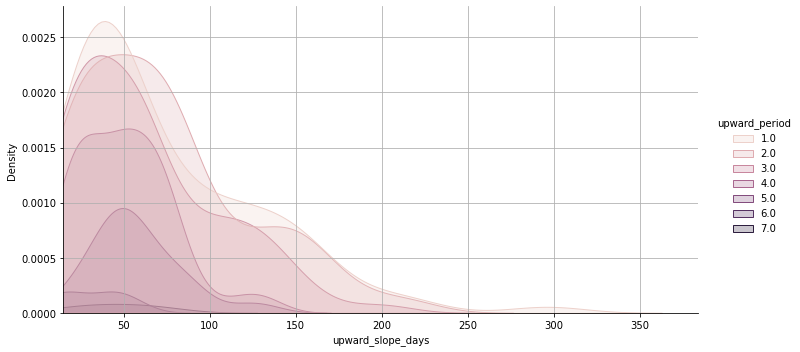

In [15]:
plt.figure()
sns.displot(df_up, x='upward_slope_days', hue='upward_period', kind='kde', fill=True, aspect=2).set(xlim=15)
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

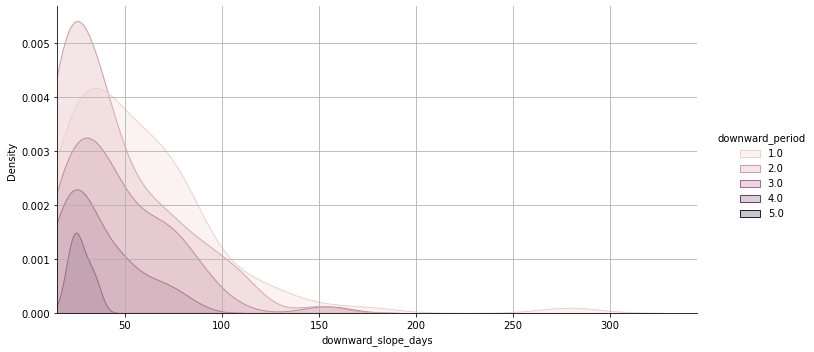

In [16]:
plt.figure()
sns.displot(df_down, x='downward_slope_days', hue='downward_period', fill=True, kind='kde', aspect=2).set(xlim=15)
plt.grid()
plt.show()

C:\Users\bendikno\Miniconda3\envs\epidemics\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

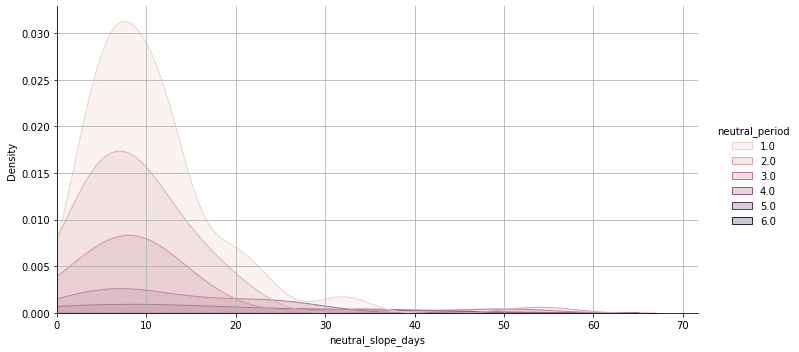

In [17]:
plt.figure()
sns.displot(df_neutral, x='neutral_slope_days', hue='neutral_period', fill=True, kind='kde', aspect=2).set(xlim=0)
plt.grid()
plt.show()

In [24]:
from collections import Counter
horizon = 60
with open('data/wave_parameters.json') as file:
    data = json.load(file)
transition_mat = pd.read_csv('data/wave_transition.csv', index_col=0).T.to_dict()

R_timeline = np.ones(horizon)
current_state = 'U'
wave_state_history = []
i = 0
while True:
    wave_state_history.append(current_state)
    n_wave = Counter(wave_state_history)[current_state]
    params = data['duration'][current_state][str(n_wave)]
    duration = skewnorm.rvs(params['skew'], loc=params['mean'], scale=params['std']) // 7 # weeks
    duration = min(max(duration, params['min']), params['max'])
    try:
        for week in range(i, i+int(duration)):
            params = data['R'][current_state][str(n_wave)]
            R = skewnorm.rvs(params['skew'], loc=params['mean'], scale=params['std'])
            R = min(max(R, params['min']), params['max'])
            R_timeline[week] = R
        i += int(duration)
        current_state = np.random.choice(['U', 'D', 'N'], p=list(transition_mat[current_state].values()))
    except:
        print("Timeline generated")
        break

Timeline generated


In [25]:
R_timeline

array([1.57419869, 1.51735757, 1.6382211 , 1.89327431, 1.81777832,
       1.7259465 , 1.03502654, 1.33637411, 1.51496457, 1.75320013,
       1.32109711, 1.66467816, 1.49618372, 1.4333692 , 1.83048621,
       1.376973  , 1.33786904, 1.38000744, 1.76228989, 1.50404523,
       0.73663996, 0.7844539 , 0.77810581, 0.91213861, 0.92862756,
       0.81123232, 0.78564082, 0.90039094, 0.90380573, 0.83868228,
       0.73046282, 0.82207542, 0.99817796, 0.82431306, 1.1118479 ,
       1.48405996, 1.303201  , 1.3419348 , 1.31391898, 1.41359633,
       1.32788719, 1.2351905 , 1.5253037 , 1.48530287, 1.27942211,
       1.27533352, 1.36574043, 1.30189986, 0.83974943, 1.00077297,
       1.32263153, 1.46893461, 1.21481167, 1.21444454, 1.28741608,
       1.23820787, 1.32384428, 1.49777359, 1.65420269, 1.53829409])

In [26]:
wave_state_history

['U', 'D', 'U', 'N', 'U']